# Movies RecSys

In this notebook, I firt imported a subset of the orginal dataset, representing a 4% (used 1M out of a total of 25M obervations)
The goal, as explained in the README file in this repository, is to create a Recommender System that given historical data on  22.7 million unique users, is capable and does make personalized recommendations to the user.

In this case, I have added a couple of cells at the end that lets the user to input their favorite movies, and the model will get help from this first input in order to avoid a cold start. 

A different approach, which could be taken is to basically add each new user together with their favorite movies to the existing dataset, and basically get the RecSys to make recommendations based on that. This last option is more straight forward, and definetely somethign to try out. 

In [3]:
import pandas as pd
from surprise import Reader

I tried to join most of the datasets, in order to build a more robust recommender but my kernel kept crushing (NOTE: Currently using my M2 Mac Pro, which should be able a lot). 
I could have used my other more powerful GPUs such as the T4 GPU + high ram, on Google Colab. For this RecSys I decided to keep it simple and local, so I had to adjust the complexity of the system. 

In [4]:
file_path1 = '/Users/rogerlbcn/Library/CloudStorage/OneDrive-Personal/Python_Projects/Movies_RecSys_GENERAL/ml-25m/ratings.csv'
file_path2 = '/Users/rogerlbcn/Library/CloudStorage/OneDrive-Personal/Python_Projects/Movies_RecSys_GENERAL/ml-25m/movies.csv'

# ratings_df = pd.read_csv(file_path2, nrows=1000000) # NOTE: The kernel doesn't crush with 1M observations
ratings_df = pd.read_csv(file_path1, nrows=1000000) # Using 1 Million observations
movies_df = pd.read_csv(file_path2, nrows=1000000) # Using 1 Million observations

## Inspecting dataset

In the following cells, we will inspect the dataset/s to see the data distribution, understand each of the variables, and address missing values if any. After this step we will pass on to the next phase, model implementation and training. 

In [5]:
ratings_df

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
999995,6747,3566,2.0,1008568732
999996,6747,3578,5.0,998488633
999997,6747,3593,2.0,997996934
999998,6747,3615,4.0,998592422


In [6]:
rating_count = ratings_df.count()
rating_count


userId       1000000
movieId      1000000
rating       1000000
timestamp    1000000
dtype: int64

In [7]:
ratings_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [8]:
ratings_df = ratings_df.drop(columns=['timestamp'])  # Features excluding 'movieId'

In [9]:
ratings_df

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5
...,...,...,...
999995,6747,3566,2.0
999996,6747,3578,5.0
999997,6747,3593,2.0
999998,6747,3615,4.0


In [10]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   userId   1000000 non-null  int64  
 1   movieId  1000000 non-null  int64  
 2   rating   1000000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 22.9 MB


In [11]:
ratings_df.describe()

,userId,movieId,rating
count,1000000.000000,1000000.000000,1000000.000000
mean,3414.023267,21108.987256,3.532902
std,1924.322666,39075.605217,1.057824
min,1.000000,1.000000,0.500000
25%,1751.000000,1136.000000,3.000000
50%,3445.000000,2826.000000,3.500000
75%,5108.000000,8370.000000,4.000000
max,6747.000000,208939.000000,5.000000


In [12]:
ratings_df['rating'].unique()

array([5. , 3.5, 4. , 2.5, 4.5, 3. , 0.5, 2. , 1. , 1.5])

In [13]:
for i in ratings_df:
    print(i)

userId
movieId
rating


In [14]:
from surprise import Dataset
from surprise import Reader

# Define a Reader object specifying the rating scale
reader = Reader(rating_scale=(0, 5))  # Assuming your ratings range from 1 to 5

data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [15]:
data

In [16]:
len(ratings_df)

1000000

The Following ratings histogram is skewed to the right. This gives us a sense of how users in our `ratings_df` dataset, tend to rate movies. This could be due to a couple of things.
1. The movies collected are generally the most popular ones

    **OR**

2. Users tend to rate movies higher than lower. 

Since our recommender could be impacted by this dynamic, I went ahead and also inspected the `movies_df` dataset to see what movies the DS has. Most of them correspond were released in the last century, quite old, and besides some classics like Jumanji or Starwars, I haven't really heard of the rest. Therefore we'll make the assumption that users tend to rate movies high. This will help us later on understand the findings better. 

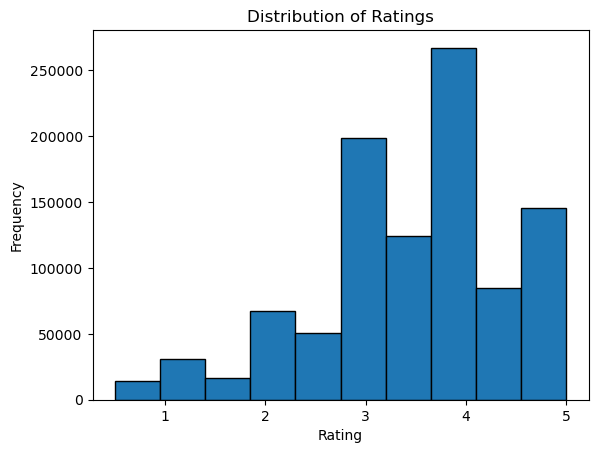

In [17]:
import matplotlib.pyplot as plt

ratings_df['rating'].plot(kind='hist', bins=10, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


## Train-test split

Getting the `ratings_df` dataset (the only one that we'll use to train the model) ready by splitting the data the following way: train_set (80%) and test_set (20%).

In [18]:
from surprise.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)



## Creating and fitting the model (`KNNBasic`)

Observations: 
- In a different notebook, 5M oversvations were used, for this same model, `KNNBasic`. It took the model 13 min 47 sec to run, but its performance didn't significantly improve. Therefore, I decided to use a 1M subset of the 5M subset, since the original dataset is formed by 25M of these. 

In [19]:
from surprise import KNNBasic

# Define similarity options
sim_options = {
    'name': 'cosine',       # Use cosine similarity
    'user_based': False,    # Compute item-item similarity
    'min_support': 5        # Minimum number of common ratings
}

# Initialize the model 
model_1 = KNNBasic(k = 20, 
                   min_k = 5, 
                   sim_options = sim_options, 
                   verbose = True)

# Train the model on the training set
model_1.fit(train_set)


Computing the cosine similarity matrix...
Done computing similarity matrix.


## Creating predictions on the test set

In [20]:
# Creating some predicitons on the test set:

predictions = model_1.test(test_set)
predictions[:5] # showing the first 5

[Prediction(uid=102, iid=4571, r_ui=4.5, est=4.2994047991649005, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=2401, iid=21, r_ui=4.0, est=4.075308200669512, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=2469, iid=40583, r_ui=3.5, est=3.3503686084454545, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=5588, iid=6242, r_ui=4.0, est=4.050536032347512, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=462, iid=5464, r_ui=3.5, est=3.574998666936551, details={'actual_k': 20, 'was_impossible': False})]

In the following cell, we have inputed the `userId`: #890. When we run it we get all the ratings and their movie IDs, this user has made. 

In [21]:
### Using the ur method ###
# Checking user 890's ratings 

train_set.ur[890]

[(733, 4.0),
 (1159, 3.0),
 (2698, 3.0),
 (1040, 4.0),
 (226, 4.0),
 (1869, 3.0),
 (56, 3.0),
 (2570, 3.0),
 (1856, 3.0),
 (22, 3.0),
 (591, 3.0),
 (723, 2.0),
 (2703, 5.0),
 (428, 4.0),
 (656, 4.0),
 (4167, 4.0),
 (3159, 3.0),
 (3603, 3.0),
 (1783, 3.0),
 (1734, 3.0),
 (2683, 3.0),
 (1770, 4.0),
 (2998, 3.0),
 (2043, 3.0),
 (775, 3.0),
 (3535, 4.0),
 (774, 3.0),
 (99, 3.0),
 (14, 3.0),
 (638, 3.0),
 (1786, 3.0),
 (1975, 3.0),
 (668, 3.0),
 (810, 2.0),
 (885, 3.0),
 (155, 3.0),
 (912, 3.0),
 (224, 3.0),
 (1507, 3.0),
 (838, 4.0),
 (640, 3.0),
 (658, 4.0),
 (445, 3.0),
 (725, 4.0),
 (1150, 3.0),
 (695, 2.0),
 (471, 4.0),
 (4643, 3.0),
 (1094, 4.0),
 (869, 3.0),
 (813, 3.0),
 (324, 3.0),
 (404, 4.0),
 (636, 3.0),
 (881, 3.0),
 (1289, 3.0),
 (328, 4.0),
 (574, 3.0),
 (477, 3.0),
 (1208, 5.0),
 (81, 3.0),
 (291, 3.0),
 (4455, 4.0),
 (1581, 3.0),
 (264, 3.0),
 (77, 3.0),
 (45, 3.0),
 (4375, 3.0),
 (1490, 4.0)]

In [22]:
# Calculating the RMSE of the RecSys Model:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 0.9284


0.9284291171136813

In [23]:
# Convert test_set to a list of tuples (user, item, rating)
test_ratings = [(uid, iid, true_r) for uid, iid, true_r in test_set if uid in train_set._raw2inner_id_users and iid in train_set._raw2inner_id_items]
test_df = pd.DataFrame(test_ratings, columns=['userId', 'movieId', 'rating'])

# Predict ratings for test set
test_df['predicted_rating'] = test_df.apply(lambda x: model_1.predict(x['userId'], x['movieId']).est, axis=1)

# Merge with movie names
test_df = pd.merge(test_df, movies_df, on='movieId')

from sklearn.metrics import mean_squared_error
import numpy as np

# Evaluate the model
rmse = np.sqrt(mean_squared_error(test_df['rating'], test_df['predicted_rating']))
print(f'Test RMSE: {rmse}')

# Display the results with movie names
print(test_df[['userId', 'movieId', 'title', 'rating', 'predicted_rating']])

Test RMSE: 0.9265781436414785
        userId  movieId                                         title  rating  \
0          102     4571       Bill & Ted's Excellent Adventure (1989)     4.5   
1         1831     4571       Bill & Ted's Excellent Adventure (1989)     5.0   
2         1273     4571       Bill & Ted's Excellent Adventure (1989)     4.0   
3         3049     4571       Bill & Ted's Excellent Adventure (1989)     4.0   
4         4053     4571       Bill & Ted's Excellent Adventure (1989)     4.0   
...        ...      ...                                           ...     ...   
198390    6543     2276      Soldier's Daughter Never Cries, A (1998)     4.0   
198391    5659    79029                Kurt Cobain About a Son (2006)     3.0   
198392    2003    52413  Ulysses' Gaze (To Vlemma tou Odyssea) (1995)     4.0   
198393    3150   173879                           Shimmer Lake (2017)     3.5   
198394     653     5733              Eyewitness (Janitor, The) (1981)     4.0  

In [24]:
# Convert test_set to a list of tuples (user, item, rating)
test_ratings = [(uid, iid, true_r) for uid, iid, true_r in test_set if uid in train_set._raw2inner_id_users and iid in train_set._raw2inner_id_items]
test_df = pd.DataFrame(test_ratings, columns=['userId', 'movieId', 'rating'])

# Predict ratings for test set
test_df['predicted_rating'] = test_df.apply(lambda x: model_1.predict(x['userId'], x['movieId']).est, axis=1)

# Merge with movie names
test_df = pd.merge(test_df, movies_df, on='movieId')

# Evaluate the model
rmse = np.sqrt(mean_squared_error(test_df['rating'], test_df['predicted_rating']))
print(f'Test RMSE: {rmse}')

# Display the results with movie names
print(test_df[['userId', 'movieId', 'title', 'rating', 'predicted_rating']])

Test RMSE: 0.9265781436414785
        userId  movieId                                         title  rating  \
0          102     4571       Bill & Ted's Excellent Adventure (1989)     4.5   
1         1831     4571       Bill & Ted's Excellent Adventure (1989)     5.0   
2         1273     4571       Bill & Ted's Excellent Adventure (1989)     4.0   
3         3049     4571       Bill & Ted's Excellent Adventure (1989)     4.0   
4         4053     4571       Bill & Ted's Excellent Adventure (1989)     4.0   
...        ...      ...                                           ...     ...   
198390    6543     2276      Soldier's Daughter Never Cries, A (1998)     4.0   
198391    5659    79029                Kurt Cobain About a Son (2006)     3.0   
198392    2003    52413  Ulysses' Gaze (To Vlemma tou Odyssea) (1995)     4.0   
198393    3150   173879                           Shimmer Lake (2017)     3.5   
198394     653     5733              Eyewitness (Janitor, The) (1981)     4.0  

## Plotting the `model` (KNNBasic)

There is no sign of overfitting at this point. 

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0573
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0086
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9914
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9826


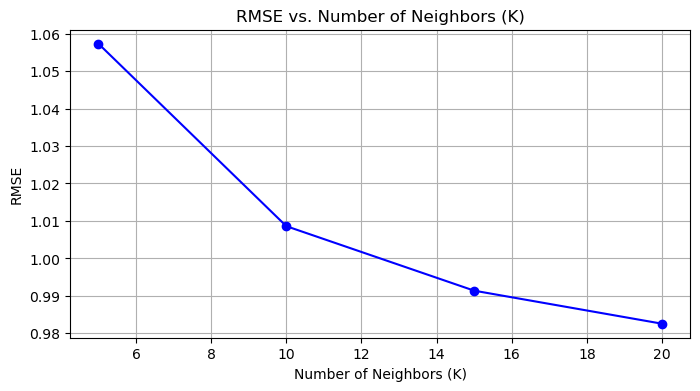

In [25]:
import matplotlib.pyplot as plt

# List of K values for K-Nearest Neighbors
# k_values = [5, 10, 15, 20, 25]
k_values = list(range(5, 25, 5))  # Testing K values from 5 to 50 with a step of 5
rmse_scores = []

for k in k_values:
    model_1 = KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': True})
    model_1.fit(train_set)
    predictions = model_1.test(test_set)
    rmse = accuracy.rmse(predictions)
    rmse_scores.append(rmse)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(k_values, rmse_scores, marker='o', linestyle='-', color='b')
plt.title('RMSE vs. Number of Neighbors (K)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


## Confusion matrix:

The following is a Confusion matrix, which is not appropiate for this type of models, since it's not classification. That said, even though that's the case, it gives us a good understanding of how effective our model is and how it performs. 


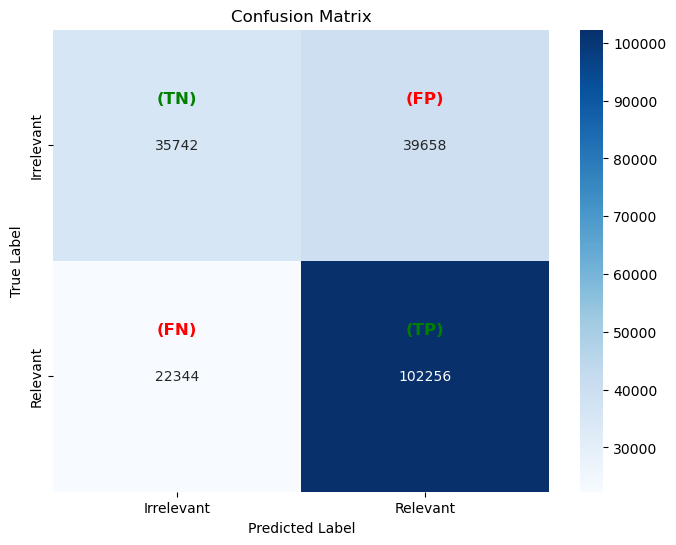

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Sample predictions
# predictions = [(uid, iid, true_r, est, _) for your data]

# Binarize the ratings (threshold set to 3.5 for relevant/irrelevant classification)
threshold = 3.5
y_true = np.array([1 if true_r >= threshold else 0 for (_, _, true_r, _, _) in predictions])
y_pred = np.array([1 if est >= threshold else 0 for (_, _, _, est, _) in predictions])

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix with annotations
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Irrelevant", "Relevant"], yticklabels=["Irrelevant", "Relevant"]) 
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add custom annotations
quad_texts = [['(TN)', '(FP)'], ['(FN)', '(TP)']]
positions = [(0.5, 0.3), (1.5, 0.3), (0.5, 1.3), (1.5, 1.3)]
colors = ['green', 'red', 'red', 'green']

for pos, text, color in zip(positions, [text for row in quad_texts for text in row], colors):
    ax.text(pos[0], pos[1], text, ha='center', va='center', color=color, fontsize=12, fontweight='bold')

plt.show()


In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming y_true and y_pred are already defined as in the previous example
# y_true = np.array([...])
# y_pred = np.array([...])

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"True Positive (TP): {TP}")
print(f"False Positive (FP): {FP}")
print(f"True Negative (TN): {TN}")
print(f"False Negative (FN): {FN}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Confusion Matrix:
[[ 35742  39658]
 [ 22344 102256]]
True Positive (TP): 102256
False Positive (FP): 39658
True Negative (TN): 35742
False Negative (FN): 22344
Accuracy: 0.6900
Precision: 0.7205
Recall: 0.8207
F1 Score: 0.7674


As seen in the confusion matrix above and the the calculation below, False negatives and false positives represent about 30% of the data, which is ok. Although it's always better to keep it low, we can generally work with this. 

In [28]:
TT = TN + TP
FF = FN + FP

Total = TT + FF
percentage = (FF/Total)*100
percentage

31.001

The RSME below for our SDV model underperforms the KNNBasic model

In [29]:
from surprise import SVD
from surprise import accuracy

In [30]:
model_2 = SVD() # svd recommender
model_2.fit(train_set)

svd_predictions = model_2.test(test_set)

RMSE_model_2 = accuracy.rmse(svd_predictions)

RMSE_model_2

RMSE: 0.8333


0.83325443079513

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
import numpy as np
import pandas as pd

# Binarize the ratings (threshold set to 3.5 for relevant/irrelevant classification)
threshold = 3.5
y_true = np.array([1 if true_r >= threshold else 0 for (_, _, true_r, _, _) in svd_predictions])
y_pred = np.array([1 if est >= threshold else 0 for (_, _, _, est, _) in svd_predictions])

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"True Positive (TP): {TP}")
print(f"False Positive (FP): {FP}")
print(f"True Negative (TN): {TN}")
print(f"False Negative (FN): {FN}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[54990 20410]
 [33682 90918]]
True Positive (TP): 90918
False Positive (FP): 20410
True Negative (TN): 54990
False Negative (FN): 33682
Accuracy: 0.7295
Precision: 0.8167
Recall: 0.7297
F1 Score: 0.7707


Therefore after comparing both of the above models (KNNBasic and SVD), we can say with confidence that the SVD model performs better overall. 

1. Accuracy 
    - KNNBasic: 69.57%
    - **SVD: 73.06% (Winner)**
2. Precision
    - KNNBasic: 72.83%
    - **SVD: 81.69% (Winner)**
3. Recall
    - **KNNBasic: 81.59% (Winner)**
    - SVD: 73.15%
4. F1 Score
    - KNNBasic: 76.96%
    - **SVD: 77.19% (Winner)**

**Conculsion:** 
The SVD model outperforms KNNBasic due to its higher Accuracy (the retio of finding movies that fit the user's preferences is higher), Precision (the ratio of correctly recommended movies out of all movies recommended), and F1 Score (a combined measure that accounts for both precision and recall). That said, since KNNBasic has higher Recall score, if users value the discovery of a wider range of movies, then KNNBasic would be the model to use. But unless that's the case, SVD can make better and more specific recommendations to the user. 

## `model_B2` (SVD with new parameters)

### Changing default parameters for model SVD to others:

In [32]:
from surprise import accuracy

model_2B = SVD(
    n_factors = 30,  # Number of latent factors
    n_epochs = 30,    # Number of SGD iterations
    lr_all = 0.004,   # Learning rate for all parameters. Default = 0.005
    reg_all = 0.02    # Regularization term for all parameters
)

# Fit the model on the training set
model_2B.fit(train_set)

# Test the model on the test set
svd_predictions2B = model_2B.test(test_set)

# Calculate and print the RMSE
RMSE_model2B = accuracy.rmse(svd_predictions2B)
RMSE_model2B


RMSE: 0.8284


0.8283566495254113

In [33]:
# Calculate and print the RMSE
RMSE_model2B = accuracy.rmse(svd_predictions2B)
print(f'RMSE: {RMSE_model2B}')

# Binarize the ratings (threshold set to 3.5 for relevant/irrelevant classification)
threshold = 3.5
y_true = np.array([1 if true_r >= threshold else 0 for (_, _, true_r, _, _) in svd_predictions2B])
y_pred = np.array([1 if est >= threshold else 0 for (_, _, _, est, _) in svd_predictions2B])

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate metrics
accuracy_metric = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"True Positive (TP): {TP}")
print(f"False Positive (FP): {FP}")
print(f"True Negative (TN): {TN}")
print(f"False Negative (FN): {FN}")
print(f"Accuracy: {accuracy_metric:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

RMSE: 0.8284
RMSE: 0.8283566495254113
Confusion Matrix:
[[55105 20295]
 [33037 91563]]
True Positive (TP): 91563
False Positive (FP): 20295
True Negative (TN): 55105
False Negative (FN): 33037
Accuracy: 0.7333
Precision: 0.8186
Recall: 0.7349
F1 Score: 0.7745


In [34]:
#################################################################################################################
### COMPARING THE SVD MODEL WITH DEFAULT PARAMETERS (model_2) WITH THE ONE WITH TWICKED PARAMETERS (model_2B) ###
#################################################################################################################

RMSE_model_2, RMSE_model2B

(0.83325443079513, 0.8283566495254113)

## SVD (model_B2) performance:

This model can predict movie ratings reliably. 

In terms of classification perfoamnce, this model has an accuracy of 0.73, the highest so far, whith a high presision of 0.81, which ensures relevant recommendations, as well as a recent recall at 0.73, which means it can handle a borad coverage of relevant movies for users. And finally the f1-score of 0.77 shows a balanced as well as efective overall perfomance. Together, all these metrics, make this SVD model (model_2B) quite solid (although could be further improved by applying feature engineering, normalization, cross-validaiton) for providing personalized movie recommendations. 

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
import numpy as np
import pandas as pd

# Binarize the ratings (threshold set to 3.5 for relevant/irrelevant classification)
threshold = 3.5
y_true = np.array([1 if true_r >= threshold else 0 for (_, _, true_r, _, _) in svd_predictions])
y_pred = np.array([1 if est >= threshold else 0 for (_, _, _, est, _) in svd_predictions])

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"True Positive (TP): {TP}")
print(f"False Positive (FP): {FP}")
print(f"True Negative (TN): {TN}")
print(f"False Negative (FN): {FN}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[54990 20410]
 [33682 90918]]
True Positive (TP): 90918
False Positive (FP): 20410
True Negative (TN): 54990
False Negative (FN): 33682
Accuracy: 0.7295
Precision: 0.8167
Recall: 0.7297
F1 Score: 0.7707


In [36]:
for i in movies_df:
    print(i)

movieId
title
genres


In [37]:
# # Display the list of movies
# print("Please select your favorite movies from the list below:")

# for index, row in movies_df_s.iterrows():
#     print(f"{index + 1}. {row['title']} - {row['genres']}")

# # Simulate user input (for demonstration, let's assume user likes movies 1, 5, and 10)
# user_favorites = [0, 4, 9]  # Indexes of the movies selected by the user
# selected_movie_ids = movies_df_s.iloc[user_favorites]['movieId'].tolist()
# print(f"User selected movie IDs: {selected_movie_ids}")


# # Display the list of movies
# print("Please select your favorite movies from the list below by entering the movie numbers separated by commas (e.g., 1, 5, 10):")

# for index, row in movies_df.iterrows():
#     print(f"{index + 1}. {row['title']} - {row['genres']}")

# # Collect user input
# user_input = input("Enter the numbers of your favorite movies: ")
# user_favorites = [int(num) - 1 for num in user_input.split(",")]
# selected_movie_ids = movies_df.iloc[user_favorites]['movieId'].tolist()
# print(f"User selected movie IDs: {selected_movie_ids}")

# Display the sampled list of movies
print("Please select your favorite movies from the list below by entering the movie numbers separated by commas (e.g., 1, 5, 10):")

for index, row in movies_df.iterrows():
    print(f"{index + 1}. {row['title']} - {row['genres']}")

# Collect user input (limit to 5 movies)
user_input = input("Enter the numbers of your favorite movies (up to 5): ")
user_favorites = [int(num.strip()) - 1 for num in user_input.split(",")][:5]
selected_movie_ids = movies_df.iloc[user_favorites]['movieId'].tolist()
print(f"User selected movie IDs: {selected_movie_ids}")



Please select your favorite movies from the list below by entering the movie numbers separated by commas (e.g., 1, 5, 10):
1. Toy Story (1995) - Adventure|Animation|Children|Comedy|Fantasy
2. Jumanji (1995) - Adventure|Children|Fantasy
3. Grumpier Old Men (1995) - Comedy|Romance
4. Waiting to Exhale (1995) - Comedy|Drama|Romance
5. Father of the Bride Part II (1995) - Comedy
6. Heat (1995) - Action|Crime|Thriller
7. Sabrina (1995) - Comedy|Romance
8. Tom and Huck (1995) - Adventure|Children
9. Sudden Death (1995) - Action
10. GoldenEye (1995) - Action|Adventure|Thriller
11. American President, The (1995) - Comedy|Drama|Romance
12. Dracula: Dead and Loving It (1995) - Comedy|Horror
13. Balto (1995) - Adventure|Animation|Children
14. Nixon (1995) - Drama
15. Cutthroat Island (1995) - Action|Adventure|Romance
16. Casino (1995) - Crime|Drama
17. Sense and Sensibility (1995) - Drama|Romance
18. Four Rooms (1995) - Comedy
19. Ace Ventura: When Nature Calls (1995) - Comedy
20. Money Train (19

In the input cell generated by the cell above, I entered the following movie IDs; 1, 58937, 59222, 258, 15239
The RecSys shold recommend me similar movies to the ones I entered. 

In [38]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [39]:
# Simulate new user ID
new_user_id = max(ratings_df['userId']) + 1

# Add the user favorite movie ratings to the dataset for prediction
new_ratings = pd.DataFrame([{'userId': new_user_id, 'movieId': movie_id, 'rating': 5} for movie_id in selected_movie_ids])
ratings_df = pd.concat([ratings_df, new_ratings], ignore_index=True)

# Prepare data for the recommendation model with the new user data
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
train_set = data.build_full_trainset()
model_2B.fit(train_set)

# Predict ratings for all movies the user has not rated
all_movie_ids = movies_df['movieId'].tolist()
user_rated_movies = ratings_df[ratings_df['userId'] == new_user_id]['movieId'].tolist()
movies_to_predict = [movie for movie in all_movie_ids if movie not in user_rated_movies]

# Generate recommendations
recommendations = []
for movie_id in movies_to_predict:
    pred = model_2B.predict(new_user_id, movie_id)
    recommendations.append((movie_id, pred.est))

# Sort recommendations by estimated rating
recommendations.sort(key=lambda x: x[1], reverse=True)

# Display the top 5 recommendations
top_recommendations = recommendations[:5]
print("Top 5 movie recommendations for you:")
for movie_id, est_rating in top_recommendations:
    movie_title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
    print(f"{movie_title}: estimated rating {est_rating:.2f}")

Top 5 movie recommendations for you:
Fargo (1996): estimated rating 5.00
It Happened One Night (1934): estimated rating 5.00
Rome, Open City (a.k.a. Open City) (Roma, città aperta) (1945): estimated rating 5.00
Rules of the Game, The (La règle du jeu) (1939): estimated rating 5.00
Come and See (Idi i smotri) (1985): estimated rating 5.00


Indeed! The RecSys made recommendations in similar categories: i.e. business, Syfy, and dramas. 

## Building: User-Specific Movie Recommendation Engine

The following function `get_user_predictions` doe the following:
- Identifies those movies the user in question hasn't rated
- Predicts ratings for these movies using our best-performing model: `model_B2`(SDV)
- Sorts these predicitons to find the best recommendation for the user

And finally it printed the top predictions for the user in question, which in this case is user #1

In [40]:
def get_user_predictions(model_2B, user_id, ratings_df, movies_df, n=10):
    # Get a list of all movie IDs
    all_movie_ids = set(movies_df['movieId'].unique())

    # Get the movie IDs that the user has already rated
    user_rated_movie_ids = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])

    # Find the movie IDs that the user hasn't rated yet
    unrated_movie_ids = all_movie_ids - user_rated_movie_ids

    # Predict ratings for all unrated movies
    predictions = [model_2B.predict(user_id, movie_id) for movie_id in unrated_movie_ids]

    # Sort predictions by estimated rating
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Return the top n predictions
    return predictions[:n]

# Example usage
user_id = 1  # Replace with the specific user ID
top_predictions = get_user_predictions(model_2B, user_id, ratings_df, movies_df, n=10)

for prediction in top_predictions:
    movie_id = prediction.iid
    movie_title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
    estimated_rating = prediction.est
    print(f'Movie: {movie_title}, Estimated Rating: {estimated_rating}')


Movie: Band of Brothers (2001), Estimated Rating: 4.610028267874345
Movie: Planet Earth II (2016), Estimated Rating: 4.564799103703698
Movie: Louis C.K.: Chewed Up (2008), Estimated Rating: 4.537051952473869
Movie: Planet Earth (2006), Estimated Rating: 4.5141295028230735
Movie: Lives of Others, The (Das leben der Anderen) (2006), Estimated Rating: 4.489654588306309
Movie: Schindler's List (1993), Estimated Rating: 4.474905367876988
Movie: Wild Tales (2014), Estimated Rating: 4.4586341105676945
Movie: Spirited Away (Sen to Chihiro no kamikakushi) (2001), Estimated Rating: 4.448628660387838
Movie: Man Who Planted Trees, The (Homme qui plantait des arbres, L') (1987), Estimated Rating: 4.427184056690162
Movie: Twin Peaks (1989), Estimated Rating: 4.403273531588903


## Conclusion:

In this notebook, we developed a simplified movie recommendation system using a subset of the MovieLens dataset. Here's a summary of the key steps and findings:

1. Utilized 1 million ratings from the MovieLens dataset.
    - Preprocessed data for the surprise library, fitting it for collaborative filtering.

2. Model Training:

    - Trained an SVD (Singular Value Decomposition) model on 75% of the data, with 25% reserved for testing.

3. Cold Start Problem:

    - Implemented a feature allowing users to input favorite movies to improve initial recommendations.

4. Personalized Recommendations:

    - Created the Personalized Movie Predictor function to generate recommendations for specific users.
    - Predicted ratings for unrated movies and returned top recommendations.

**Example Usage:**

Demonstrated how to use the function with a specific user ID to generate and display top movie recommendations.

### Future Work:

To enhance the recommendation system further, consider the following improvements:

- Hybrid Models: Combine collaborative filtering with content-based filtering to leverage both user behavior and movie metadata.
- Real-time Recommendations: Implement real-time data processing and recommendation generation to provide instant suggestions as user preferences change.
- User Interface: Develop a user-friendly web application to interact with the recommendation system, allowing users to input preferences and receive recommendations seamlessly.

This project lays a solid foundation for building and deploying a movie recommendation system. By continuing to refine the model and integrating it into a web application, we can create a robust tool that delivers personalized movie suggestions to users effectively.

## Papers Citations:

**KNNBasic model:**

Nguyen LV, Vo Q-T, Nguyen T-H. Adaptive KNN-Based Extended Collaborative Filtering Recommendation Services. Big Data and Cognitive Computing. 2023; 7(2):106. https://doi.org/10.3390/bdcc7020106

**SVD model:**

Widiyaningtyas T, Ardiansyah MI, Adji TB. Recommendation Algorithm Using SVD and Weight Point Rank (SVD-WPR). Big Data and Cognitive Computing. 2022; 6(4):121. https://doi.org/10.3390/bdcc6040121